**Install Packages**

In [1]:
import tensorflow as tf

from keras.models import Sequential
# Importing all the different layers and optimizers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU, Input,GlobalAveragePooling2D, Resizing
from keras.optimizers import Adam,SGD
from keras.preprocessing import image_dataset_from_directory
from keras.layers import Rescaling, RandomFlip, RandomRotation
from keras.callbacks import  EarlyStopping, ReduceLROnPlateau
from  keras_tuner import Hyperband,HyperModel
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import numpy as np
from keras.regularizers import l2

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import random
import shutil
# Set the random seed for TensorFlow
tf.random.set_seed(42)

# Set the random seed for NumPy
np.random.seed(42)

# Set the random seed for Python's built-in random module
random.seed(42)

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages are logged (default behavior), 1 = INFO messages are not printed, 2 = INFO and WARNING messages are not printed, 3 = INFO, WARNING, and ERROR messages are not printed

# Optionally, suppress other warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_GPU_TIMER_WARNING'] = '0'  # Suppress GPU timer warning

# # Disable NUMA support
# tf.config.experimental.set_virtual_device_configuration(
#     tf.config.experimental.list_physical_devices('GPU')[0],
#     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)]
# )

2024-12-14 10:49:09.547762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734191349.623737   25384 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734191349.628499   25384 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-14 10:49:09.748916: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


**load data**

In [2]:
picture_size = 48
folder_path = "Facial_emotion_images/"
emotions = ['happy', 'sad', 'neutral', 'surprise']

#batch size
batch_size  = 128

# Load the training dataset
train_set_color = image_dataset_from_directory(folder_path + 'train/',
                                              image_size = (48, 48),
                                              color_mode = "rgb",
                                              batch_size = batch_size,
                                              label_mode = 'categorical',
                                              #classes = emotions,
                                              shuffle = True)
# Load the validation dataset
validation_set_color = image_dataset_from_directory(folder_path + 'validation/',
                                              image_size =(48, 48),
                                              color_mode = "rgb",
                                              batch_size = batch_size,
                                              label_mode = 'categorical',
                                              #classes = emotions,
                                              shuffle = True)
# Load the test dataset
test_set_color = image_dataset_from_directory(folder_path + 'test/',
                                              image_size = (48, 48),
                                              color_mode = "rgb",
                                              batch_size = batch_size,
                                              label_mode = 'categorical',
                                              #classes = emotions,
                                              shuffle = True)

# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_set_color = train_set_color.cache().prefetch(buffer_size=AUTOTUNE)

validation_set_color = validation_set_color.cache().prefetch(buffer_size=AUTOTUNE)


Found 15109 files belonging to 4 classes.


I0000 00:00:1734191357.102223   25384 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6073 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 4977 files belonging to 4 classes.
Found 128 files belonging to 4 classes.


**Load transfer model**

In [3]:
from keras.applications import VGG16
VGG16_model = VGG16(weights='imagenet', include_top=False)
VGG16_model.summary()
for layer in VGG16_model.layers:
    layer.trainable = False

# Unfreeze the top layers for fine-tuning
for layer in VGG16_model.layers[-3:]:
    layer.trainable = True

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

**Best Model**

In [9]:
class cnn_model_color_VGG16_model(HyperModel):
    def build(self,hp):
        # Intializing a sequential model

        cnn_model = Sequential()
        # Adding the input layer
        cnn_model.add(Input(shape=(48, 48,3)))
        # Adding a random flip layer
        cnn_model.add(RandomFlip('horizontal'))
        # Adding a random rotation layer
        cnn_model.add(RandomRotation(0.2))
        
        # Add the Rescaling layer at the beginning
        cnn_model.add(Rescaling(1./255))
        
        #resize the image to 224x224
        cnn_model.add(Resizing(224, 224))
        # Add the VGG16 model
        cnn_model.add(VGG16_model)
        # Add convolutional layers
        
        cnn_model.add(GlobalAveragePooling2D())  

        # Adding a sequential layer with 300 neurons
        cnn_model.add(Dense(hp.Int('layer1',min_value=200,max_value=500,step=25), activation='relu', kernel_regularizer=l2(0.01)))
        cnn_model.add(BatchNormalization())
        # Adding a sequential layer with dropout of 0.2
        cnn_model.add(Dropout(0.2))
        # Adding a sequential layer with 200 neurons
        cnn_model.add(Dense(hp.Int('layer2',min_value=32,max_value=300,step=25), activation='relu', kernel_regularizer=l2(0.01)))
        cnn_model.add(BatchNormalization())
        cnn_model.add(LeakyReLU(alpha=0.1))
        cnn_model.add(Dropout(0.2))
        cnn_model.add(Dense(hp.Int('layer3',min_value=32,max_value=300,step=25), activation='relu', kernel_regularizer=l2(0.01)))
        cnn_model.add(BatchNormalization())
                    
        cnn_model.add(Dropout(0.2))
        # Adding a batch normalization layer
        
        # Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
        cnn_model.add(Dense(4, activation='softmax'))


        
        # Using Adam Optimizer
        opt = Adam(learning_rate=0.0001)

        # Compile model
        cnn_model.compile(optimizer=opt,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
        
        return cnn_model


In [5]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# Clear the Keras backend session
tf.keras.backend.clear_session()

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)


In [ ]:
hypermodel = cnn_model_color_VGG16_model()

tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    seed=seed_value,
    directory='my_dir',
    project_name='final_project_2'
    
)

tuner.search(train_set_color, validation_data=validation_set_color, epochs=30)

best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('final_model_2.keras')

Trial 5 Complete [00h 01m 55s]
val_accuracy: 0.43258991837501526

Best val_accuracy So Far: 0.5760498046875
Total elapsed time: 00h 11m 30s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
200               |275               |layer1
182               |257               |layer2
82                |107               |layer3
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


In [6]:
best_model = tf.keras.models.load_model('final_model_1.keras')
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = best_model.fit(
            train_set_color, 
            validation_data = validation_set_color,
            epochs=30,
            shuffle=True,
            batch_size=128,
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True),
                            ReduceLROnPlateau(monitor = 'val_loss',
                                factor = 0.2,
                                patience = 3,
                                verbose = 1,
                                min_delta = 0.0001)]
            )

Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 56s 456ms/step - accuracy: 0.5772 - loss: 1.0614 - val_accuracy: 0.3920 - val_loss: 3.8858 - learning_rate: 0.0010
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.5854 - loss: 1.0088 - val_accuracy: 0.3269 - val_loss: 2.1559 - learning_rate: 0.0010
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 55s 461ms/step - accuracy: 0.6301 - loss: 0.8709 - val_accuracy: 0.4599 - val_loss: 1.8429 - learning_rate: 0.0010
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 55s 461ms/step - accuracy: 0.6384 - loss: 0.8820 - val_accuracy: 0.5951 - val_loss: 1.0986 - learning_rate: 0.0010
Epoch 5/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 55s 461ms/step - accuracy: 0.6617 - loss: 0.8193 - val_accuracy: 0.5668 - val_loss: 1.4561 - learning_rate: 0.0010
Epoch 6/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 55s 461ms/step - accuracy: 0.6762 - loss: 0.7923 - val_accuracy: 0.6799 - val_loss: 0.7459 - learning_rate: 0.0010
Epoch 7/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 55s 460ms/step - accuracy: 0.6

1/1 - 1s - 572ms/step - accuracy: 0.7969 - loss: 0.5123
VGG16_model test accuracy:  0.796875


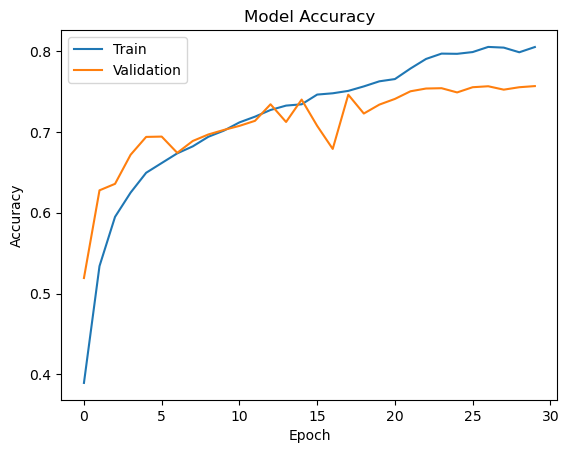

VGG16_model test accuracy:  0.796875


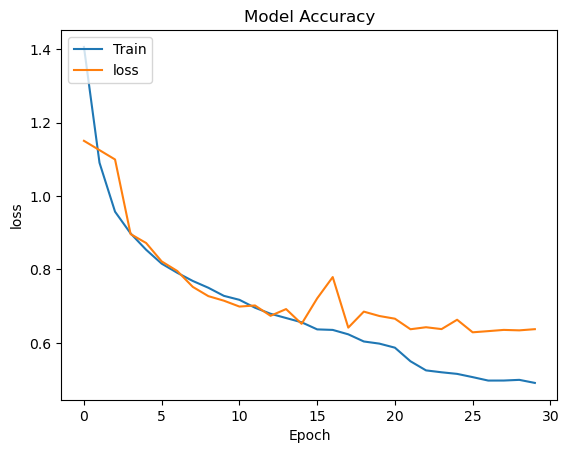

In [ ]:
# Generating the summary of the model
model_color_VGG16_model.summary()

model_color_VGG16_model.save('final_model.keras')

accuracy = model_color_VGG16_model.evaluate(test_set_color, verbose = 2)
print("VGG16_model test accuracy: ", accuracy[1])
#plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print("VGG16_model test accuracy: ", accuracy[1])
#plot the training and validation accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'loss'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

test_images, test_labels = next(iter(test_set_color))

y_pred =  model_color_VGG16_model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis = 1)


print(classification_report(y_true, y_pred, target_names=emotions))
# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['happy', 'sad', 'neutral', 'surprise'], yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()